In [23]:
%matplotlib inline
# %load utils_topicality.py
import os,sys
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import re
import ipdb


data_dir = "../datasets/semeval_2010_t1_eng/data"
#libs_dir = "hdp"
#sys.path.append(libs_dir)
from hdp.ugs import *

numpy.seterr(divide='ignore')

split_re = re.compile(r'([()|])')
INF = 1e10

class Event:
	def __init__(self,_phrase='',_pos='NN',_priority=INF,_fin_phrase=-np.inf):
		self.phrase = _phrase
		self.pos = _pos
		self.priority = _priority
		self.entity_id = -1
		self.fin_phrase = _fin_phrase
		

	def __str__(self):
		res = "[ phrase:%s\n  pos: %s\n  priority: %i\n  entity_id: %i]" % (self.phrase,self.pos,self.priority,self.entity_id)
		return res

	def __repr__(self):
		res = "[ phrase:%s\n  pos: %s\n  priority: %i\n  entity_id: %i]" % (self.phrase,self.pos,self.priority,self.entity_id)
		return res

'''
read data and preprocess
@param filename: relative or absolute training filename
return
	(documents: [doc| doc=(entity,pos,entity_id)]
	 vocabulary: list of entities as vocabulary
	)
'''
def getdata(filename,n_docs='all'):

	documents = []
	sentence = []
	vocabulary = set()
	count_docs = 0

	for line in open(filename):
		line = line.strip('\n')
		if line.startswith('#begin'):
			doc = []
			sentence=[]
			event = Event()
			open_events = [event]
			continue
			#all temp files are reset
		if line.startswith('#end'):
			#save all temp docs
			doc = np.array(doc)
			documents.append(doc)
			count_docs+=1
			if n_docs!='all':
				if count_docs>=n_docs:
					break
			continue
		
		if line!='':
			temp1 = line.split('\t')
			sentence.append(temp1)

		if line=='':
			# build tree
			nn = len(sentence)+1
			dep_graph = [[] for i in xrange(nn)]
			nodes_depth = np.zeros(nn)
			root = -1
			for comp in sentence:
				u = int(comp[0])
				v = int(comp[8])
				dep_graph[u].append(v)
				dep_graph[v].append(u)
				if v==0:
					root=v
			# assign height to nodes with BFS
			queue = [root]
			visited = np.zeros(nn)
			while len(queue)!=0:
				curr_node = queue.pop()
				if visited[curr_node]!=1:
					visited[curr_node]=1
					for v in dep_graph[curr_node]:
						if visited[v]!=1 and nodes_depth[v]<nodes_depth[curr_node]+1:
							nodes_depth[v]=nodes_depth[curr_node]+1
							queue.append(v)

			# Extract entities
			for comp in sentence:
				event = open_events[-1]
				n_tok = int(comp[0])
				token = comp[1]
				pos = comp[4]
				synt_head = nodes_depth[n_tok] # corrected height
				coref_str = comp[-1]

				if pos not in ['NNP','NNPS'] and token!="I": # lowercase any other than proper nouns
					token = token.lower()

				for i in xrange(len(open_events)):
					event = open_events[i]
					# continue building phrase
					if pos[0]=='N' and pos==event.pos and n_tok==event.fin_phrase+1:
						if event.phrase!='':
							event.phrase+=' '
						event.phrase+=token
						event.priority = min(event.priority,synt_head)
						event.fin_phrase+=1
						open_events[i] = event
					# update ENTITY
					elif pos in ['NN','NNS','NNP','NNPS','PRP','PRP$'] and synt_head<event.priority:
							# conserve ENTITY_ID
							new_event = Event(token,pos,synt_head,n_tok)
							new_event.entity_id = event.entity_id
							open_events[i] = new_event

				if coref_str=='_':
					continue

				# pos in ['NN','NNS','NNP','NNPS','PRP','PRP$'] and 
				temp = split_re.split(coref_str)
				splitted = [a for a in temp if a!='']
				k=0
				while(k<len(splitted)):		# | no hace nada
					if splitted[k]=='(':
						priority = np.inf
						if pos in ['NN','NNS','NNP','NNPS','PRP','PRP$']:
							priority = synt_head
						event = Event(token,pos,priority,n_tok)	# initialization
						open_events.append(event)
					elif splitted[k].isdigit():
						id = 0
						id = int(splitted[k])
						open_events[-1].entity_id = id # si es nuevo asigna, sino chanca el [mismo] id al ultimo activo
					elif splitted[k]==')':
						if open_events[-1].pos in ['NN','NNS','NNP','NNPS','PRP','PRP$']:
							text = open_events[-1].phrase
							ev_pos = open_events[-1].pos
							ent_id = open_events[-1].entity_id
							doc.append(tuple([text,ev_pos,ent_id]) )
							vocabulary.add(open_events[-1].phrase)	# build vocab
						open_events.pop()
					k+=1
			#END-FOR-ENTITIES

			#reset sentence var
			sentence = []
		#END-IF-EMPTY-LINE
	#END-FOR-FILE
	documents = np.array(documents)
	vocabulary = list(vocabulary)
	return documents,vocabulary

'''
@param refs_by_doc: [doc | doc:{"lex":{ref:freq}, "pro":{ref:freq} }]
return ( docs: {id | doc[id]:[ref_id]}
		 refs_vocab: vocabulary of only referents)
'''
def index_docs(documents):
	N = len(documents)
	new_documents = {}
	refs_vocab = []
	for i in xrange(N):
		doc = documents[i]
		new_doc = []
		for ref,freq in doc["lex"].items():
			ref_id = -1
			if ref not in refs_vocab:
				ref_id = len(refs_vocab)
				refs_vocab.append(ref)
			else:
				ref_id = refs_vocab.index(ref)
			new_doc += freq*[ref_id]

		for ref,freq in doc["pro"].items():
			ref_id = -1
			if ref not in refs_vocab:
				ref_id = len(refs_vocab)
				refs_vocab.append(ref)
			else:
				ref_id = refs_vocab.index(ref)
			new_doc += freq*[ref_id]
		new_documents[i]=new_doc
	return new_documents,refs_vocab

def add(_dict,key,val):
	if key not in _dict:
		_dict[key]=0
	_dict[key]+=val
	return

"""
Extracts referent chains, assigns the referent and separate by lex or pro, + frequency
return
	refs_by_doc: [doc | doc:{"lex":{ref:freq}, "pro":{ref:freq} }]
	ref_by_token: {(pos_weight,token):[referents]}
"""
def get_referents(documents):
	N = documents.shape[0]

	ref_by_token = {}
	pos_weights = {
		'NNP':0,
		'NNPS':0,
		'NN':5,
		'NNS':5,
		'PRP':10,
		'PRP$':10
	}
	refs_by_doc = []
	for i in xrange(N):
		chains = {}
		lexical_noun_refs = {}
		pronoun_refs = {}

		# get annotated correference chains
		for (ent,pos,ent_id) in documents[i]:
			if ent_id not in chains:
				chains[ent_id] = set()
			if (ent,pos) not in chains[ent_id]:
				chains[ent_id].add((pos_weights[pos],ent))
		
		# get lexical nouns and pronouns referents
		for (ent_id,ref_chain) in chains.items():
			chain = set(ref_chain)
			(pos_w,ref) = chain.pop()
			if pos_w==10:	# Only Nouns as referents
				continue
			# add to lexical_noun referents
			add(lexical_noun_refs,ref,1)
			# map token to referent
			token = ref
			if (pos_w,token) not in ref_by_token:
				ref_by_token[(pos_w,token)] = set()
			ref_by_token[(pos_w,token)].add(ref)

			while(len(chain)>0):
				pos_w,token = chain.pop()
				if pos_w==10:
					add(pronoun_refs,ref,1)
				else:
					add(lexical_noun_refs,ref,1)
				# map token to referent
				if (pos_w,token) not in ref_by_token:
					ref_by_token[(pos_w,token)] = set()
				ref_by_token[(pos_w,token)].add(ref)

		# save by doc
		doc = {}
		doc["lex"] = lexical_noun_refs
		doc["pro"] = pronoun_refs
		refs_by_doc.append(doc)
	return refs_by_doc,ref_by_token
		
"""
Assigns k from argmax p(xij|k,t). p(z_{ji}|G_j) = gamma * Gamma(gamma) * Gamma(m_{.k}) * fact(gamma-1) / fact(m_{..}+gamma-1)
"""
def log_pz(hdp,document_index,word,vocab):
	word_index = hdp._vocab.index(vocab.index(word))
	max_topic_index = hdp.assign_topic_word(word_index)

	if max_topic_index==-1:
		return -np.inf
		
	# p(t_{ij}=t)
	"""
	table_log_likelihood = len(hdp._k_dt[document_index]) * np.log(hdp._alpha) - log_factorial(len(hdp._t_dv[document_index]), hdp._alpha);
	for table_index in xrange(len(hdp._k_dt[document_index])):
	    table_log_likelihood += scipy.special.gammaln(hdp._n_dt[document_index][table_index]);
	table_log_likelihood += scipy.special.gammaln(hdp._alpha);
	"""

	# p(k_{jt}=z_{ji}|t_{ji})
	topic_log_likelihood = np.log(hdp._gamma) - log_factorial(np.sum(hdp._m_k), hdp._gamma)
	topic_log_likelihood += scipy.special.gammaln(hdp._m_k[max_topic_index]);
	topic_log_likelihood += scipy.special.gammaln(hdp._gamma);

	return  topic_log_likelihood #* table_log_likelihood


"""
p(z_{ji}|G_j) = n_{j.k} / Sum(n_{j..})
"""
def log_pz_ml(hdp,document_index,word,vocab):
	word_index = hdp._vocab.index(vocab.index(word))
	log_pz = np.log(hdp._n_kd[:,document_index]) - np.log(np.sum(hdp._n_kd[:,document_index]))
	k = log_pz.argmax()
	return log_pz.max()

def expectation_ref(refs,hdp,doc_idx,vocab):
	E_log_pz = 0
	n_refs = 0
	for ref,freq in refs.items():
		n_refs += freq
		E_log_pz += freq*log_pz(hdp,doc_idx,ref,vocab)
	if n_refs==0:
		return -np.inf
	E_log_pz /= n_refs
	return E_log_pz

def expectation_ref_counts(refs,doc):
	E_log_pz = 0
	n_total = sum(doc["lex"].values())
	n_total += sum(doc["pro"].values())
	n_refs = 0
	
	for ref,freq in refs.items():
		n_refs += freq
		E_log_pz += np.log(freq) - np.log(n_total)		# p(ri) = C_{j,ri} / C_{j.}

	if n_refs==0:
		return -np.inf
	E_log_pz /= n_refs
	return E_log_pz

'''
@param refs_by_doc: [doc | doc:{"lex":{ref:freq}, "pro":{ref:freq} }]
return 
'''
def get_lr_format(refs_by_doc,hdp,refs_vocab):
	# model 1: only p_ri
	# model 2: p_ri; p(z|t,k)
	X = []
	Y = []
	N = len(refs_by_doc)
	for i in xrange(N):
		doc = refs_by_doc[i]
		c_d = sum(doc["lex"].values())
		c_d += sum(doc["pro"].values())
		for ref,freq in doc["lex"].items():
			log_pri = np.log(freq) - np.log(c_d)
			log_pz_ref = log_pz(hdp,i,ref,refs_vocab)

			X.append([log_pri,log_pz_ref])
			Y.append(0)

		for ref,freq in doc["pro"].items():
			log_pri = np.log(freq) - np.log(c_d)
			log_pz_ref = log_pz(hdp,i,ref,refs_vocab)

			X.append([log_pri,log_pz_ref])
			Y.append(1)
	return (X,Y)




### Setup parameters

In [14]:
n_docs="all"
gibbs_iterations=1000
gamma = 1.0
alpha = 1.0
eta = 0.01
data_dir = "../datasets/semeval_2010_t1_eng/data"
data_file = os.path.join(data_dir,'en.train.txt')

### Reading and formating data

In [15]:
docs,vocab = getdata(data_file,n_docs=n_docs)
# get referents by doc
refs_by_doc,ref_by_token = get_referents(docs)
# format for HDP
formated_docs,referents_vocab = index_docs(refs_by_doc)


### Running Hierarchical Dirichlet Process

In [16]:
gs = UncollapsedGibbsSampling(50);
gs._initialize(formated_docs,gamma=gamma,alpha=alpha,eta=eta)
gs.sample(iteration=gibbs_iterations,directory='output/');

sampling in progress  1%
total number of topics 154, log-likelihood is -134667.596852
sampling in progress  2%
total number of topics 158, log-likelihood is -134279.396978
sampling in progress  3%
total number of topics 164, log-likelihood is -133728.014652
sampling in progress  4%
total number of topics 167, log-likelihood is -133845.697866
successfully export the snapshot to output/ for iteration 50...
sampling in progress  5%
total number of topics 165, log-likelihood is -133813.828435
sampling in progress  6%
total number of topics 165, log-likelihood is -133942.390110
sampling in progress  7%
total number of topics 165, log-likelihood is -133665.073731
sampling in progress  8%
total number of topics 161, log-likelihood is -133369.146823
sampling in progress  9%
total number of topics 164, log-likelihood is -133365.473300
successfully export the snapshot to output/ for iteration 100...
sampling in progress 10%
total number of topics 165, log-likelihood is -133317.078463
sampling in

### Top n words by topics, ordered by p(k)...

In [17]:
gs.print_topics(referents_vocab,5)

k  | logp    | words
------------------------------------------------
  0| -5267.30 |	people, country, years, time, today, 
 24| -6048.46 |	year, Co., %, companies, years, 
  1| -6079.13 |	Palestinians, talks, officials, Israelis, meeting, 
 16| -6270.80 |	court, lawyers, prosecutors, information, case, 
 15| -6283.75 |	government, nation, rebels, officials, attempt, 
 20| -6289.97 |	Iraq, Wednesday, Sunday, United States, Middle East, 
  6| -6289.97 |	explosion, Yemen, sailors, investigators, members, 
 14| -6298.96 |	year, %, period, profit, payments, 
 11| -6304.68 |	crew, Baghdad, boat, water, weapons, 
  3| -6307.46 |	attack, destroyer, security, Pentagon, spokesman, 
 19| -6310.16 |	rates, %, rate, market, Inc, 
 10| -6312.80 |	President Vojislav Kostunica, Belgrade, Democratic Opposition, Slobodan Milosevic, elections, 
 51| -6315.37 |	administration, man, sailors, Norwegians, revelations, 
 13| -6315.37 |	thousands, rally, seats, demonstrators, police, 
 28| -6317.85 |	day, pro

### Calculating topicality measure q_d


Media test for E_pro and E_lex: (p value)
3.05312840239e-24


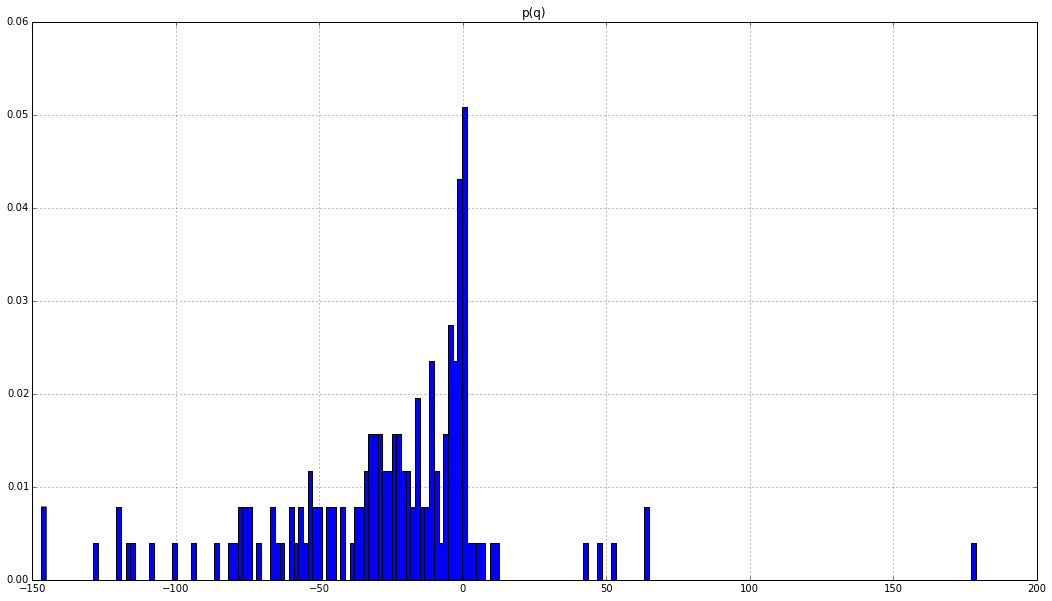

In [30]:
N = len(docs)
e_lex = np.zeros(N)
e_pro = np.zeros(N)
# Calc E_pro and E_lex
for doc_index in xrange(N):
    E_lex = expectation_ref(refs_by_doc[doc_index]["lex"],gs,doc_index,referents_vocab)
    E_pro = expectation_ref(refs_by_doc[doc_index]["pro"],gs,doc_index,referents_vocab)
    e_lex[doc_index] = E_lex
    e_pro[doc_index] = E_pro

# Calc qd: topicalty measure
qd = e_pro - e_lex
# don't consider cases where e_pro==-INF
noinf_idx = qd!=-np.inf
# median test
stat,p,m,_ = scipy.stats.median_test(e_pro[noinf_idx],e_lex[noinf_idx])

print("\nMedia test for E_pro and E_lex: (p value)")
print(p)

#p(q) as histogram
plt.figure(figsize=(18,10))
plt.hist(qd[noinf_idx],200,normed=True)
plt.title("p(q)")
plt.grid(True)
plt.show()

### Make table  | Target | Referent | topic_id

In [19]:
# make: -pos_w,k_ord_idx,tuple_id
target_ref_k = {} # pos_w: [k_ord,tupleid]
token_ref_id = [] # token, ref as word_ids

for ( (pos_w,token),refs ) in ref_by_token.items():
    for ref in refs:
        if ref==token:
            continue
        tr_idx = tuple([vocab.index(token),vocab.index(ref)])		# using global vocabulary
        tuple_id = -1
        if tr_idx in token_ref_id:
            tuple_id = token_ref_id.index(tr_idx)
        else:
            tuple_id = len(token_ref_id)
            token_ref_id.append(tr_idx)

        ref_id = gs._vocab.index(referents_vocab.index(ref))		# get referent id in HDP vocab
        k = gs.assign_topic_word(ref_id)
        k_ord_idx = np.nonzero(gs._ord_topics_pk[:,1]==k)[0][0]
        if pos_w not in target_ref_k:
            target_ref_k[pos_w] = []
        target_ref_k[pos_w].append( (k_ord_idx,tuple_id) )

for key in target_ref_k.keys():
    target_ref_k[key].sort()

## plot: target | referent | topic_id
max_per_pos = 10
print("\n%30s | %30s | Ordered topic index" % ("Target","Referent"))
print("----------------------------------------------------------------------------")
for pos,tups in target_ref_k.items():
    for i in xrange(max_per_pos):
        k_ord_idx ,tup_id = tups[i]
        target = vocab[ token_ref_id[tup_id][0] ]
        ref    = vocab[ token_ref_id[tup_id][1] ]
        #k = gs._ord_topics_pk[k_ord_idx,1]

        print("%30s | %30s | %i" % (target,ref,k_ord_idx))
    print("----------------------------------------------------------------------------")


                        Target |                       Referent | Ordered topic index
----------------------------------------------------------------------------
   President Francesco Cossiga |                         leader | 0
                  Ariel Sharon |                         leader | 0
                  Palestinians |          Palestinian Authority | 2
                          Gaza |                     Gaza Strip | 2
                        Castle |                  Andrew Castle | 3
             E. Robert Wallach |                        Wallach | 4
                       Webster |           CIA Director Webster | 4
                    US Admiral |           Admiral Robert Nader | 6
             President Clinton |                    Mr. Clinton | 6
                          Aden |                           port | 6
----------------------------------------------------------------------------
                         their |                         people | 0
           

### Significance tests for Qd


Calculating q_d for p(ri|doc_d) from corpus...

Media test for E_pro and E_lex: (p value)
0.000709204463433


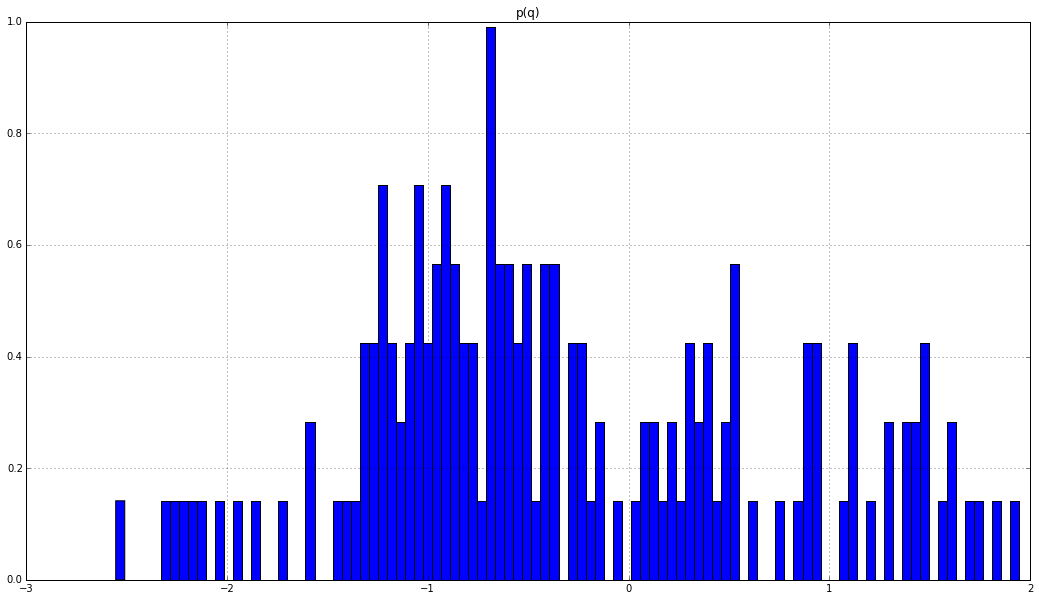

In [32]:
###########
# Media test using prob referents directly from corpus (p_{ri}=c_{ri}/c_d)
print("\nCalculating q_d for p(ri|doc_d) from corpus...")	
e_lex_corpus = np.zeros(N)
e_pro_corpus = np.zeros(N)
# Calc E_pro and E_lex
for doc_index in xrange(N):
    E_lex = expectation_ref_counts(refs_by_doc[doc_index]["lex"],refs_by_doc[doc_index])
    E_pro = expectation_ref_counts(refs_by_doc[doc_index]["pro"],refs_by_doc[doc_index])
    e_lex_corpus[doc_index] = E_lex
    e_pro_corpus[doc_index] = E_pro

# Calc qd: topicalty measure
qd_corpus = e_pro_corpus - e_lex_corpus
# don't consider cases were e_pro==-INF
noinf_idx = qd_corpus!=-np.inf
# median test
stat,p,m,_ = scipy.stats.median_test(e_pro_corpus[noinf_idx],e_lex_corpus[noinf_idx])

print("\nMedia test for E_pro and E_lex: (p value)")
print(p)

#p(q) as histogram
plt.figure(figsize=(18,10))
plt.hist(qd_corpus[noinf_idx],100,normed=True)
plt.title("p(q)")
plt.grid(True)
plt.show()


In [ ]:
# Logistic Regression models setup
# get features for models 1 and 2 and export to csv for further analysis in R
x,y = get_lr_format(refs_by_doc,gs,referents_vocab)
output = open("lr_models.csv",'w')
output.write("Y,X1,X2\n")
for i in xrange(len(y)):
    output.write("%i,%.4f,%.4f\n" % (y[i],x[i][0],x[i][1]))

In [1]:
qd

NameError: name 'qd' is not defined